Here's a Multinomial Bayes Classifier model to detect fake news. The model is trained on fake news dataset published on Kaggle (see the link below), also tested on recent articles published on Reuters website and fake articles generated by ChatGPT.

## Part 1: EDA and dataset processing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [2]:
# original datasets: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
# load fake news dataset
fake_df = pd.read_csv('news_fake.csv')

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake_df.shape

(23481, 4)

In [7]:
# check unique subjects
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [8]:
# add fake label
fake_df['label'] = 'fake'

In [9]:
# load real news dataset
true_df = pd.read_csv('news_true.csv')

In [10]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
true_df.shape

(21417, 4)

In [12]:
# check unique subjects
true_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [13]:
# rename subject labels with the corresponding ones from fake news dataset for consistency
true_df['subject'] = true_df['subject'].replace(['politicsNews', 'worldnews'], ['politics', 'News'])

In [14]:
# add true label
true_df['label'] = 'true'

In [15]:
# concatenate dataframes
news_df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)

In [16]:
news_df.head(15)

,title,text,subject,date,label
0,CNN’s Don Lemon: Is He an Alcoholic or Just a ...,"Day in and day out, CNN works hard to try and ...",Middle-east,"January 2, 2017",fake
1,Brady to offer 'substantive' U.S. tax bill ame...,WASHINGTON (Reuters) - The chairman of the Hou...,politics,"November 3, 2017",true
2,BUSTED! LIBERAL BRAINIACS Steal Trump Sign…In ...,This is just idiotic! A couple of liberal brai...,left-news,"Sep 24, 2016",fake
3,Tillerson set to meet Trudeau for North Korea ...,OTTAWA (Reuters) - U.S. Secretary of State Rex...,News,"December 11, 2017",true
4,[VIDEO] GERMAN MAYOR Blames Victims Of Mass Ra...,Because blaming the Muslim migrants who raped ...,Government News,"Jan 6, 2016",fake
5,Former FBI chief Mueller appointed to probe Tr...,WASHINGTON (Reuters) - The U.S. Justice Depart...,politics,"May 17, 2017",true
6,Senators ask if U.S. paying to secure Trump pr...,WASHINGTON (Reuters) - Three U.S. senators ask...,politics,"March 9, 2017",true
7,Trump Treasury candidate's bank accused of dis...,WASHINGTON (Reuters) - Two California housing ...,politics,"November 17, 2016",true
8,Merkel silent on fourth term despite glowing w...,BERLIN (Reuters) - U.S. President Barack Obama...,politics,"November 17, 2016",true
9,The FBI’s Russia Investigation Just Took A Tu...,The FBI is doing something with its probe into...,News,"April 5, 2017",fake


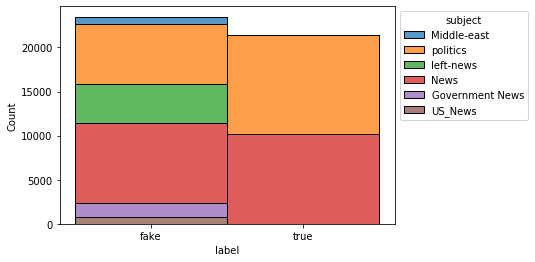

In [17]:
# check the labels and subjects distribution
# the labels are not harshly imbalanced, although fake news have more subjects
plot = sns.histplot(data=news_df, x="label", hue='subject', multiple='stack')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

In [18]:
# prepare stopwords and data for word clouds
stop_words = stopwords.words('english')
extra_words = ['Reuters', 'U', 'WASHINGTON', 'according', 'also', 'comment', 'could', 'go', 'going', 'may', 'one',
               'said', 'say', 'saying', 'told', 'would']
stop_words += extra_words
real_news_texts = ' '.join(map(str, true_df['text'].tolist()))
fake_news_texts = ' '.join(map(str, fake_df['text'].tolist()))

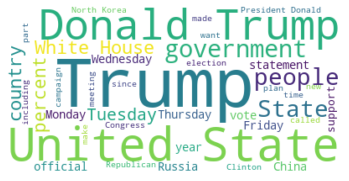

In [19]:
# real news wordcloud
realnews_wordcloud = WordCloud(min_font_size=10, max_font_size=80, max_words=100,
                      stopwords=stop_words, background_color="white").generate(real_news_texts)
plt.figure()
plt.imshow(realnews_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

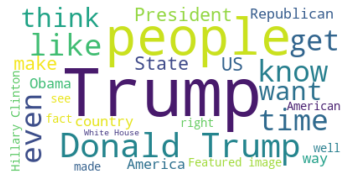

In [20]:
# fake news wordcloud
realnews_wordcloud = WordCloud(min_font_size=10, max_font_size=80, max_words=100,
                      stopwords=stop_words, background_color="white").generate(fake_news_texts)
plt.figure()
plt.imshow(realnews_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As we can see, there are some similarities related to the same topics. However, real news tend to focus on specific terms and phenomena, while fake news revolve around colloqial nouns and verbs. Interestingly, the noun 'fact' is quite frequent.

## Part 2: Fitting and evaluating the model

In [21]:
# assign integers to labels
news_df['bin_labels'] = news_df['label'].map({'fake': 0, 'true': 1})
Y = news_df['bin_labels'].to_numpy()

In [22]:
# create train and test sets
df_train, df_test, Ytrain, Ytest = train_test_split(news_df['text'], Y, test_size = 0.3)

In [23]:
# use count vectorizer
featurizer = CountVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)

In [24]:
# fit the model and evaluate it
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

print('Train accuracy:', model.score(Xtrain, Ytrain))
print('Test accuracy:', model.score(Xtest, Ytest))
print('Train F1:', f1_score(Ytrain, Ptrain))
print('Test F1:', f1_score(Ytest, Ptest))

Train accuracy: 0.9604810996563574
Test accuracy: 0.9525612472160356
Train F1: 0.9588059701492536
Test F1: 0.9503149055283415


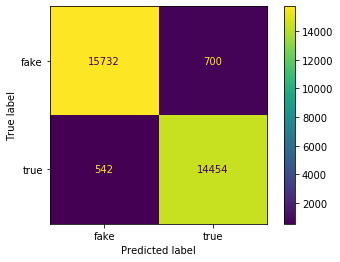

In [25]:
# create confusion matrix for the train set
cm = confusion_matrix(Ytrain, Ptrain)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=news_df.label.unique())
cm_plot.plot(values_format='d')

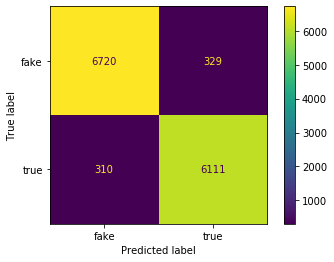

In [26]:
# create confusion matrix for the test set
cm_test = confusion_matrix(Ytest, Ptest)
cm_test_plot = ConfusionMatrixDisplay(cm_test, display_labels=news_df.label.unique())
cm_test_plot.plot(values_format='d')

## Part 3: Examples of classified texts

In [27]:
# create collections from the test dataset
false_positives = df_test[Ptest > Ytest]
false_negatives = df_test[Ptest < Ytest]
true_positives = df_test[(Ptest == 1) & (Ytest == 1)]
true_negatives = df_test[(Ptest == 0) & (Ytest == 0)]

In [28]:
# take a closer look at classified texts
print('True positive example:')
print(true_positives.sample(random_state=33).iloc[0])

True positive example:
BRUSSELS (Reuters) - The chairman of European Union leaders said on Monday he was encouraged by the progress of talks on avoiding a physical border between Ireland and Northern Ireland after Britain leaves the EU, which brought closer the prospect of starting trade talks with Britain. London wants to start talks on the future trade deal with the EU as soon as possible to provide clarity for companies based in Britain on the terms of business after exiting the EU in March 2019. But the EU said it could only start such talks once sufficient progress is made in negotiations on the terms of the divorce - a financial settlement, citizens  rights and the border between Ireland and Northern Ireland.  Tell me why I like Mondays! Encouraged after my phone call with Taoiseach (Irish Prime Minister Leo Varadkar) on progress on Brexit issue of Ireland. Getting closer to sufficient progress at December EU summit,  Donald Tusk said on Twitter. 


In [29]:
print('False positive example:')
print(false_positives.sample(random_state=33).iloc[0])

False positive example:
Secretary of State Rex Tillerson, America s top diplomat, has wanted to do a bit of reorganizing in the State Department for quite some time now in order to focus on top priorities, such as finding new economic opportunities for American businesses and strengthening the US military prowess. Now it looks like he is going to achieve his goal, just at the expense of programs to promote human rights and fight world poverty.Tillerson is apparently closing the Office of Global Criminal Justice, reassigning Todd Buchwald, the office s special coordinator since December, 2015, and a career State Department lawyer, to a position in the State Department s office of legal affairs. Buchwald was also informed that the other staff members may possibly be shifted to the State Department s Bureau of Democracy, Human Rights, and Labor.The State Department has neither confirmed nor denied the move. The State Department is currently undergoing an employee-led redesign initiative, 

This false positive was probably misclassified because of its elaborate and complex sentences which style resembles a typical news article.

In [30]:
print('True negative example:')
print(true_negatives.sample(random_state=33).iloc[0])

True negative example:
Someone should find out if Hillary supporter, Renee Zellweger had a lobotomy, while the hypocritical actress (who questioned why appearances matter so much) was having her face completely reconstructed.As Zellweger trashed Trump, she declared Hillary Clinton as one of the most  prepared  people to ever seek the presidency. There s never been anyone better prepared in our lifetime,  the actress said.Zellweger also criticized Republican nominee Donald Trump.In a lengthy interview timed to her long-awaited return to the big screen as Bridget Jones, actress Ren e Zellweger opened up about her support for Hillary Clinton, her disdain for Donald Trump and her disappointment that women in Hollywood getting older is viewed as a  negative thing. Speaking publicly about the controversy surrounding her appearance, the 47-year-old Bridget Jones s Baby actress told the Hollywood Reporter:  I ve never seen the maturation of a woman as a negative thing. I ve never seen a woman 

In [31]:
print('False negative example:')
print(false_negatives.sample(random_state=33).iloc[0])

False negative example:
WASHINGTON (Reuters) - U.S. Senator Lindsey Graham on Wednesday called out fellow Republican President Donald Trump, saying his remarks in the wake of last weekend’s violence in Charlottesville, Virginia, were dividing the nation and at odds with many Republicans’ views. “Your words are dividing Americans, not healing them,” Graham said in a statement. On Tuesday, Trump “took a step backward by again suggesting there is moral equivalency between the white supremacist neo-Nazis and KKK members who attended the Charlottesville rally and” others opposed to such groups.  


This false negative example was probably misclassified because it's too short comparing with a typical article.

## Part 4: Testing the model with completely new texts

In [32]:
# create new test set from a few recent Reuters articles and fake news generated by ChatGPT
reuters = pd.read_csv('reuters_news.csv')
generated_fake_news = pd.read_csv('fake_news_by_chatgpt.csv')
new_test_set = pd.concat([reuters, generated_fake_news]).sample(frac=1).reset_index(drop=True)
new_test_set

,title,text,label
0,Islamic state claims responsibility for killin...,March 19 (Reuters) - Islamic State claimed res...,1
1,Large-Scale Protests Erupt in South America Ov...,Large-scale protests have erupted across South...,0
2,Montenegro's President Milo Djukanovic headed ...,"PODGORICA, March 19 (Reuters) - Montenegro's v...",1
3,President of Small African Nation Claims to Ha...,The President of the small African nation of A...,0
4,"Ecuador, Peru authorities assess damage after ...",March 19 (Reuters) - Ecuadorian and Peruvian a...,1
5,Massive Cyber Attack Hits Major Banks and Corp...,A massive cyber attack has hit major banks and...,0


In [33]:
# prepare the test set
X_test = featurizer.transform(new_test_set['text'])
y_test = new_test_set['label'].to_numpy()

In [34]:
# get new predictions and evaluate
predictions = model.predict(X_test)

In [35]:
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1 2]
 [0 3]]


In [36]:
# take a look at fake news text that was correctly classified
true_negatives = new_test_set[(predictions == 0) & (y_test == 0)]
print(true_negatives['text'].iloc[0])

The President of the small African nation of Amor has made a shocking announcement today, claiming to have made contact with an alien civilization. In a press conference held this morning, President Mbeki stated that he had been contacted by extraterrestrial beings who had visited him in his office last night. According to the President, the aliens had come to deliver a message of peace and goodwill to the people of Earth. They also claimed to have advanced technology that could help solve many of the world's problems, such as climate change and disease. The announcement has been met with skepticism by many in the international community, with some questioning the President's mental state. However, the President insists that his claims are true and that he will do everything in his power to establish contact with the aliens and further communication.


In [37]:
# take a look at generated texts that were classified as real news
false_positives = new_test_set[predictions > y_test]
for text in false_positives['text']:
    print(text)

Large-scale protests have erupted across South America following the signing of a controversial trade deal between several countries in the region and the United States. The deal, which aims to increase trade and investment between the countries involved, has been met with strong opposition from labor unions and environmental groups who claim that it will lead to job losses, environmental destruction, and the exploitation of workers. In Brazil, tens of thousands of protesters have taken to the streets to voice their opposition to the deal. The protests have turned violent in some areas, with clashes breaking out between police and demonstrators. Similar protests have been reported in Argentina, Chile, and Uruguay, with many calling for the deal to be scrapped entirely. Supporters of the deal argue that it will bring much-needed economic growth to the region and create new jobs. However, opponents maintain that the benefits will be outweighed by the negative consequences and that the de

**Summary**: All real articles from Reuters were classified correctly. Fake articles happened to be trickier to classify. The model did detect implausibility in the alien story. However, it failed with other texts which had political topics frequent for typical news articles, even though they didn't contain any names, quotes or references. This indicates ChatGPT has impressive generative capability.  